### Import

In [149]:
import pandas as pd
import numpy as np
import re

from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation

from matplotlib import pyplot as plt
%matplotlib inline

### Parametere

In [150]:
n_clusters=5
#type='Interesse' 
type='Kompetanse' 
#type='Kombinert' 


### Funksjoner

In [151]:
def do_pca(df):
    pca = PCA(n_components=2)
    pca.fit(df)
    transformed_df = pca.transform(df)
    newdf = pd.concat([df.reset_index()[['Navn', 'Team']], pd.DataFrame(transformed_df)], axis=1)
    components = pd.concat([df.transpose().reset_index()['index'], pd.DataFrame({'1':pca.components_[0]}), pd.DataFrame({'2':pca.components_[1]})], axis=1).set_index('index')
    return newdf, components


def plot_pca(df):
    ms = 90
    ax = df[df['Team']=='IM'].plot(kind='scatter', x=0, y=1, s=ms, color='b', label='IM', figsize=(12,12))
    df[df['Team']=='BST' ].plot(kind='scatter', x=0, y=1, s=ms, color='r', label='BST', ax=ax)
    df[df['Team']=='ITST'].plot(kind='scatter', x=0, y=1, s=ms, color='y', label='ITST', ax=ax)

    for navn, team, x, y in df.values:
        if team == 'IM':
            horz = 'right'
        else:
            horz = 'left'
        shortname = re.match('([A-Za-z]+)\,?', navn).group(1)
        plt.annotate(shortname, xy=(x, y), textcoords = 'offset points', xytext = (0,8), horizontalalignment = horz)
    
    plt.title('PCA-analyse av %s' % type)
    pass

def plot_component(components, ind):
    components_im = components[components['Kategori']=='IM']
    components_bst = components[components['Kategori']=='BST']
    components_itst = components[components['Kategori']=='ITST']
    components_tverr = components[components['Kategori']=='Tverrfaglige kompetanser ']

    fig = plt.figure(figsize=(25,25))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)print()

    p1 = plt.barh(components_im.index, components_im.sort(str(ind))[str(ind)], left=0, color='b')
    p2 = plt.barh(components_bst.index, components_bst.sort(str(ind))[str(ind)], left=0,color='r')
    p3 = plt.barh(components_itst.index, components_itst.sort(str(ind))[str(ind)], left=0,color='g')
    if(type=='Kombinert' or type=='Kompetanse'):
        p4 = plt.barh(components_tverr.index, components_tverr.sort(str(ind))[str(ind)], left=0,color='y')

    axes.set_yticks(components.index)
    axes.set_yticklabels(components['index'], figure=fig, size=20)
    
    plt.title('PCA-komponent %d for analyse av %s' % (ind,type))
    
    plt.show()
    pass

### Datasett

In [152]:
df = pd.io.parsers.read_csv(type+"_formatert.csv", sep=';', index_col=[0,1])
df.dropna(how='any', inplace=True)


### PCA-analyse

In [153]:
newdf, components = do_pca(df)

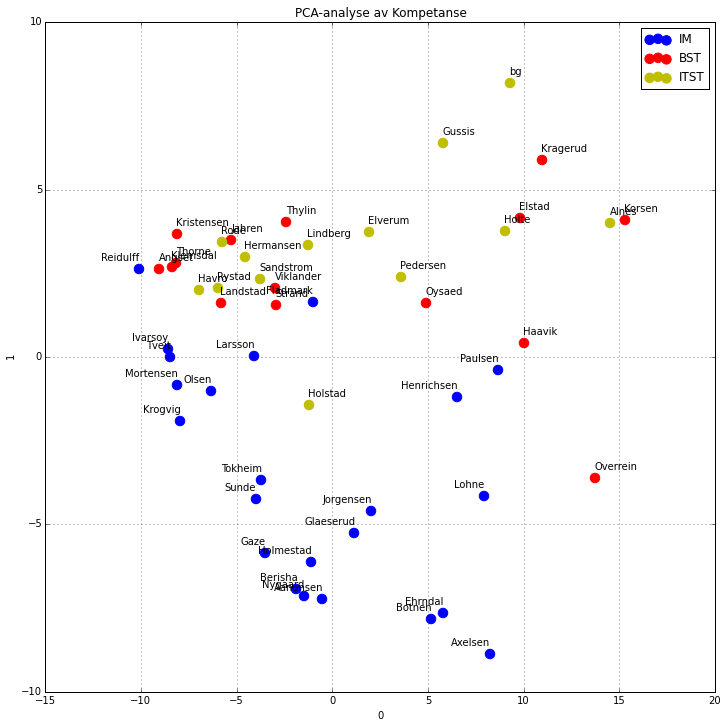

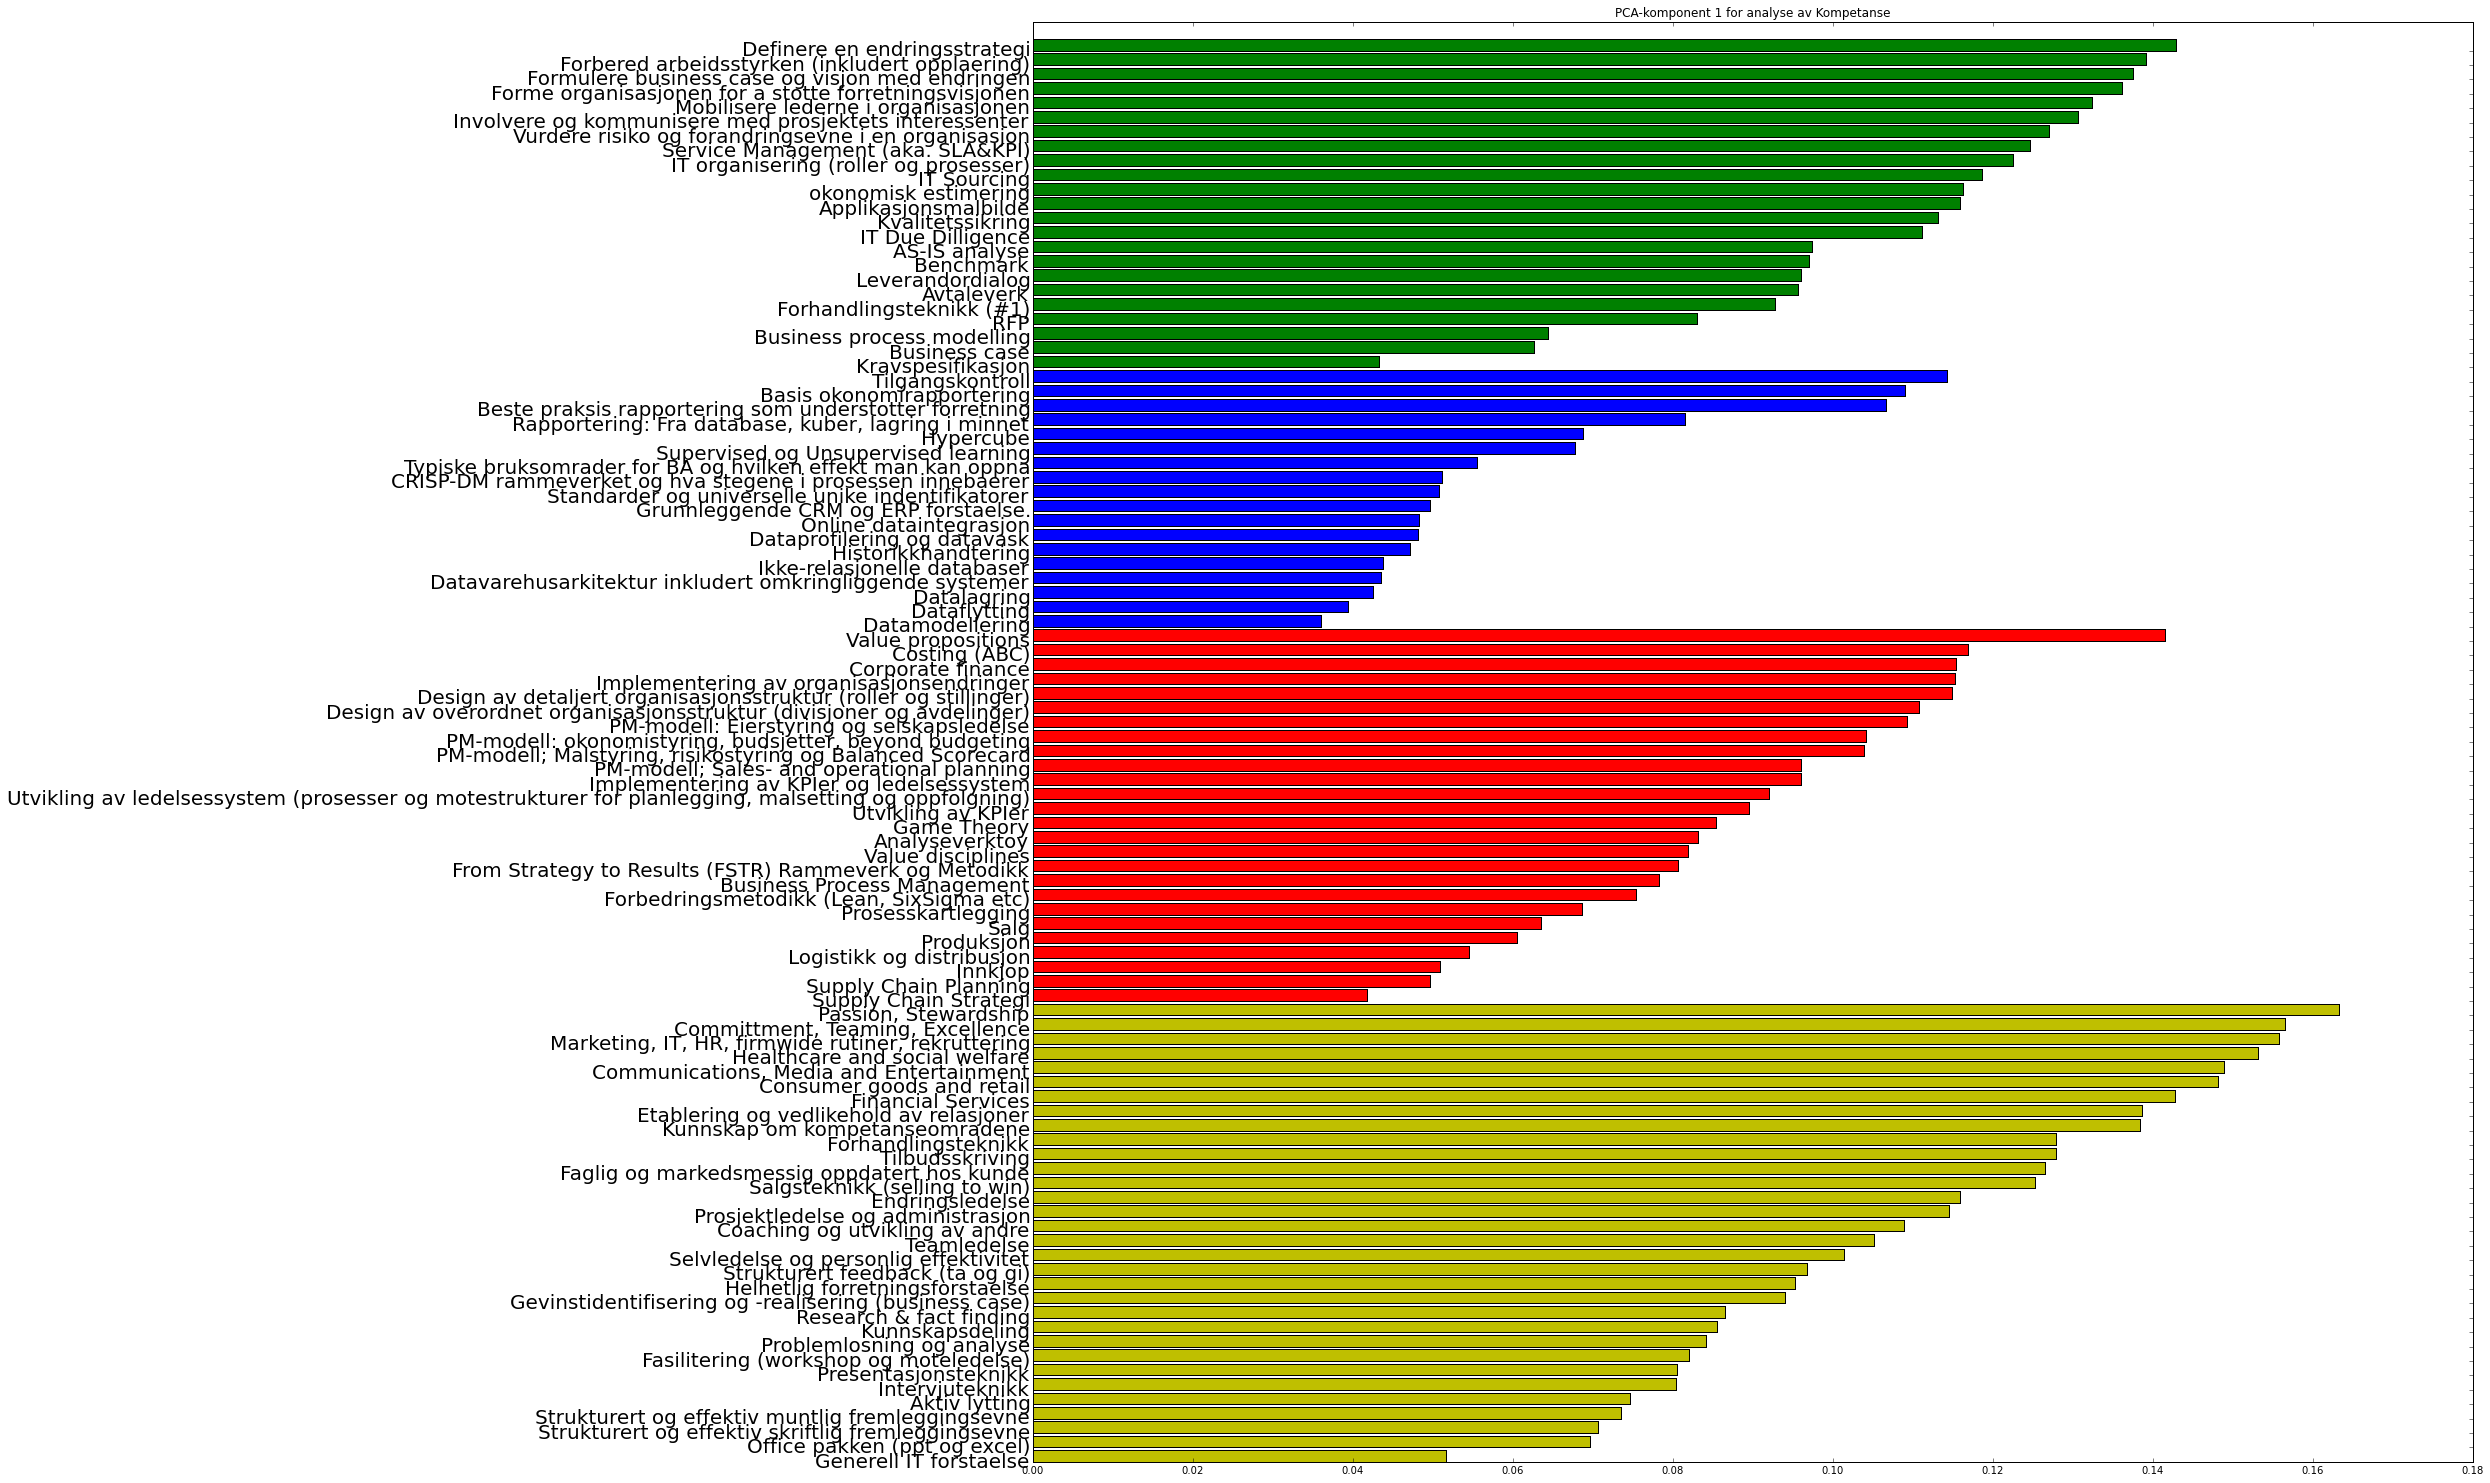

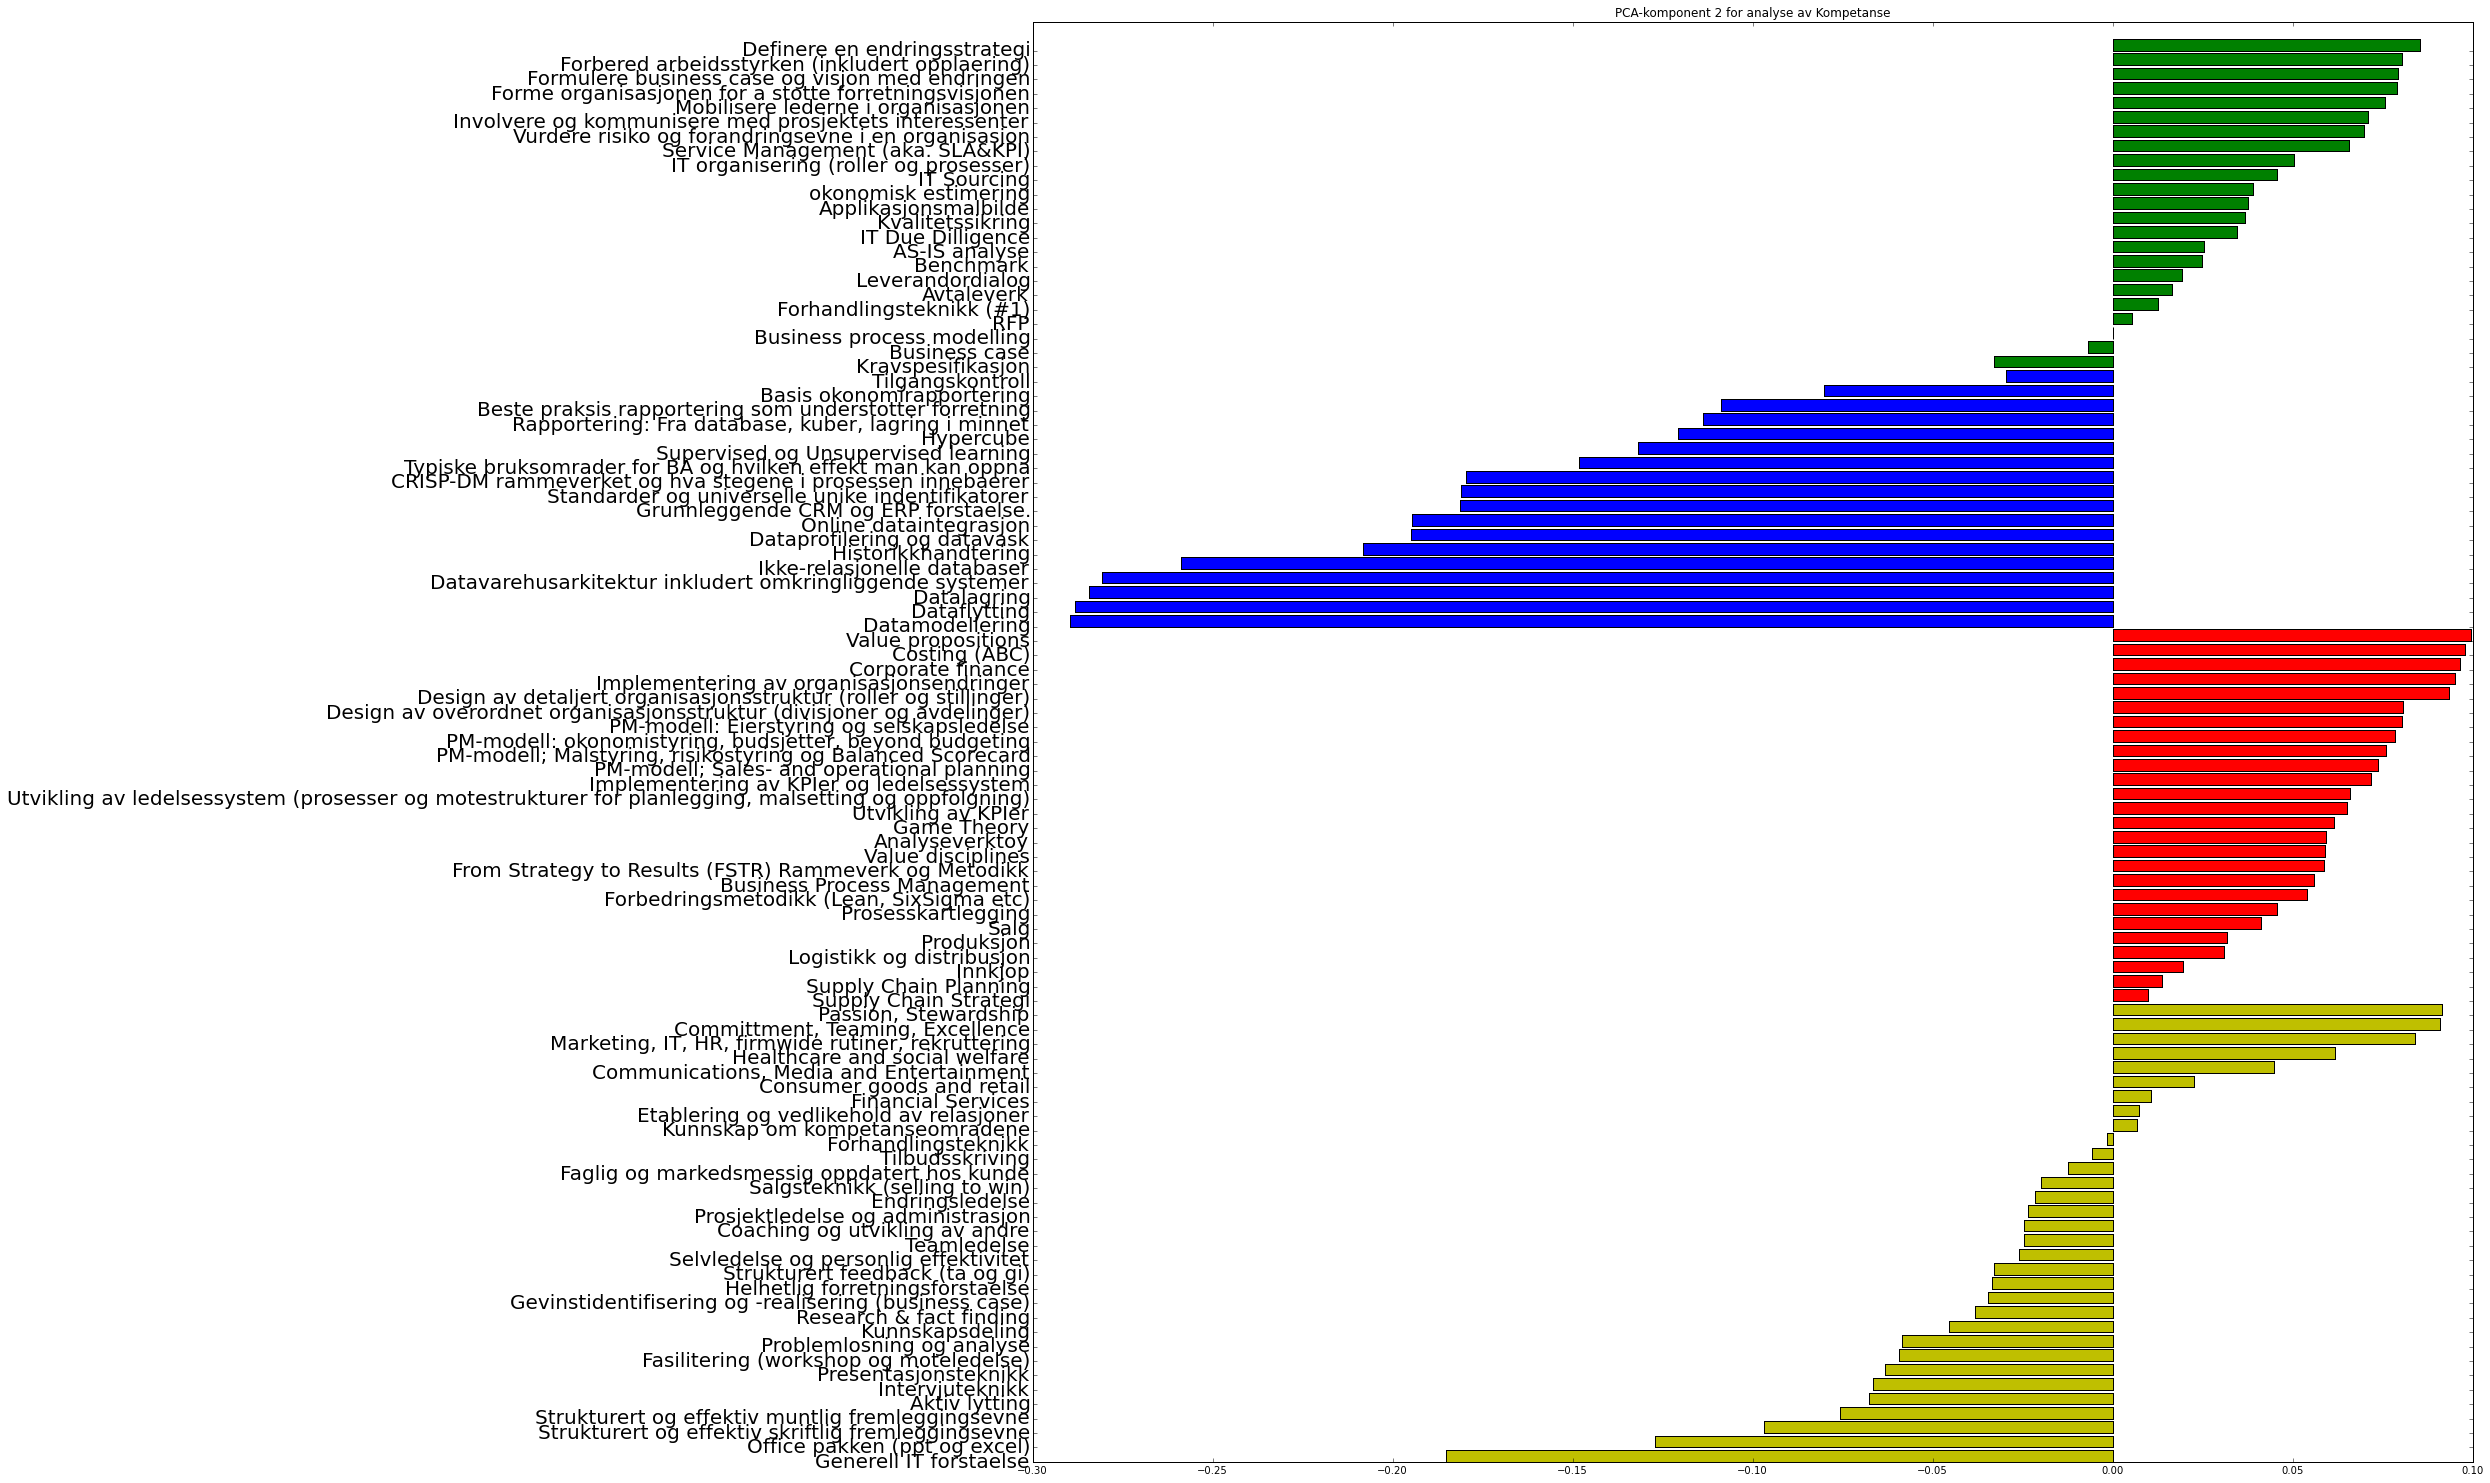

In [154]:
# Hent inn kategorier per kompetanse/interesse
kompetanse_type= pd.io.parsers.read_csv('Kategorier kompetanse og interesser.csv', sep=';', header=0, usecols=[1])
interesse_type= pd.io.parsers.read_csv('Kategorier kompetanse og interesser.csv', sep=';', header=None, usecols=[1], skiprows=33)
interesse_type.columns=['Kategori']
kombinert_type = pd.concat([kompetanse_type,interesse_type], axis=0, ignore_index=True)

if type=='Kompetanse':
    feature_type=kompetanse_type
elif type=='Interesse':
    feature_type = interesse_type
else:
    feature_type = kombinert_type

components.reset_index(inplace=True)
components = pd.concat([components, feature_type], axis=1)

plot_pca(newdf)
plot_component(components,1)
plot_component(components,2)


### KMeans-clustering

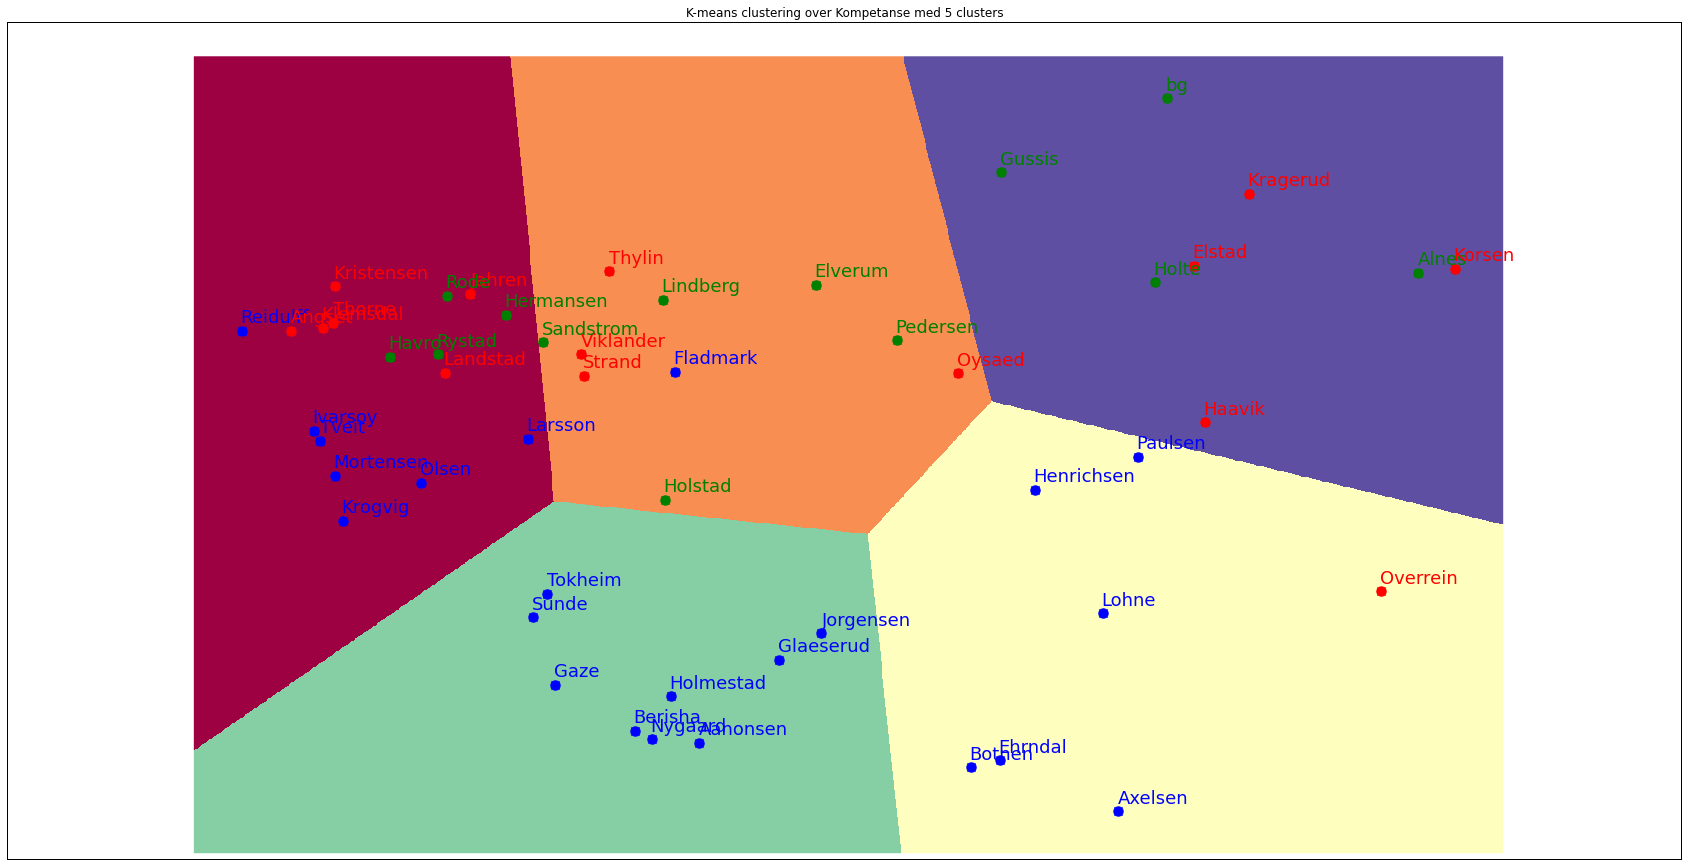

In [155]:
from sklearn.cluster import KMeans

cluster_df = pd.concat([pd.DataFrame(newdf[0]), pd.DataFrame(newdf[1])], axis=1)
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
kmeans.fit(cluster_df)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = cluster_df[0].min() - 1,cluster_df[0].max() + 1
y_min, y_max = cluster_df[1].min() - 1, cluster_df[1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(figsize=(30,15))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap='Spectral',
           aspect='auto', origin='lower')


# Plot the centroids as a white X
#centroids = kmeans.cluster_centers_
#plt.scatter(centroids[:,0], centroids[:,1],
#            marker='x', s=20, linewidths=3,
#            color='w', zorder=10)

plt.title('K-means clustering over %s med %d clusters' % (type, n_clusters))


cluster_df = pd.concat([df.reset_index()[['Navn', 'Team']], cluster_df], axis=1, ignore_index=True)
cluster_df.columns=['Navn','Team',0,1]

ax = plt.plot(cluster_df[cluster_df['Team']=='IM'][0], cluster_df[cluster_df['Team']=='IM'][1], 'k.', markersize=20,color='b')
plt.plot(cluster_df[cluster_df['Team']=='BST'][0], cluster_df[cluster_df['Team']=='BST'][1], 'k.', markersize=20,color='r')
plt.plot(cluster_df[cluster_df['Team']=='ITST'][0], cluster_df[cluster_df['Team']=='ITST'][1], 'k.', markersize=20,color='g')

#ax = df[df['Team']=='IM'].plot(kind='scatter', x=0, y=1, s=ms, color='Turquoise', label='IM', figsize=(12,12))
#df[df['Team']=='BST' ].plot(kind='scatter', x=0, y=1, s=ms, color='Gold', label='BST', ax=ax)
#df[df['Team']=='ITST'].plot(kind='scatter', x=0, y=1, s=ms, color='Red', label='ITST', ax=ax)

for navn, team, x, y in cluster_df.values:
    if team == 'IM':
        color = 'b'
    elif team == 'BST':
        color = 'r'
    else:
        color='g'
    shortname = re.match('([A-Za-z]+)\,?', navn).group(1)
    plt.annotate(shortname, xy=(x, y), textcoords = 'offset points', xytext = (0,8), size=18, color=color)

plt.xticks(())
plt.yticks(())
plt.show()


### Affinity propagation clustering

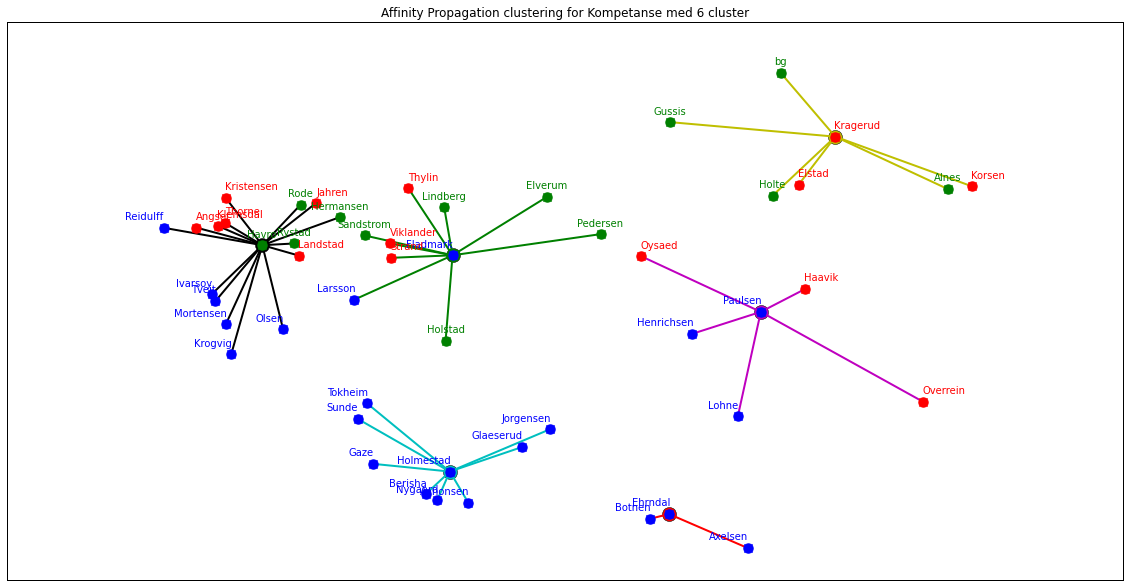

In [156]:

##############################################################################
# Compute Affinity Propagation
cluster_df = pd.concat([pd.DataFrame(newdf[0]), pd.DataFrame(newdf[1])], axis=1)
X=cluster_df.as_matrix()

af = AffinityPropagation().fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

##############################################################################
# Plot result

plt.close('all')
plt.figure(figsize=(20,10))
plt.clf()

colors = cycle('rgcmykb')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col, linewidth=2.0)

plt.title('Affinity Propagation clustering for %s med %d cluster' % (type,n_clusters_))

cluster_df = pd.concat([df.reset_index()[['Navn', 'Team']], cluster_df], axis=1, ignore_index=True)
cluster_df.columns=['Navn','Team',0,1]

ax = plt.plot(cluster_df[cluster_df['Team']=='IM'][0], cluster_df[cluster_df['Team']=='IM'][1], 'k.', markersize=20,color='b')
plt.plot(cluster_df[cluster_df['Team']=='BST'][0], cluster_df[cluster_df['Team']=='BST'][1], 'k.', markersize=20,color='r')
plt.plot(cluster_df[cluster_df['Team']=='ITST'][0], cluster_df[cluster_df['Team']=='ITST'][1], 'k.', markersize=20,color='g')

for navn, team, x, y in cluster_df.values:
    if team == 'IM':
        color = 'b'
        horz='right'
    elif team == 'BST':
        color = 'r'
        horz='left'
    else:
        color='g'
        horz='center'
    shortname = re.match('([A-Za-z]+)\,?', navn).group(1)
    plt.annotate(shortname, xy=(x, y), textcoords = 'offset points', xytext = (0,8), size=10, color=color, ha=horz)
    
plt.xticks(())
plt.yticks(())
plt.show()